# MobileNetV2 Best Hyperparameters

## Imports and Setup

In [260]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

## Load Mean and Standard Deviation Values

In [261]:
# Load mean and std values from JSON
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = np.array(mean_std['mean'])
std = np.array(mean_std['std'])

## Model Definition

In [262]:
def get_mobilenetv2_model(num_classes):
    weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.load_weights(weights_path)

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

## Data Generators

In [263]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
)
train_datagen.mean = mean
train_datagen.std = std

val_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
val_datagen.mean = mean
val_datagen.std = std

## Training and Evaluation Functions

In [264]:
def train_model(model, train_generator, val_generator, num_epochs=20, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

def evaluate_model(model, generator):
    results = model.evaluate(generator)
    return results

## Main Training and Evaluation Loop

Starting training for fold 0...
Found 384 images belonging to 4 classes.


Found 96 images belonging to 4 classes.


Epoch 1/20
24/24 [==============================] - 5s 142ms/step - loss: 1.6150 - accuracy: 0.4922 - val_loss: 1.0149 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 3s 121ms/step - loss: 0.7138 - accuracy: 0.7656 - val_loss: 0.7171 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 3s 131ms/step - loss: 0.5991 - accuracy: 0.8073 - val_loss: 0.6060 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 3s 120ms/step - loss: 0.4964 - accuracy: 0.8307 - val_loss: 0.5670 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 3s 117ms/step - loss: 0.4033 - accuracy: 0.8594 - val_loss: 0.5254 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 3s 128ms/step - loss: 0.3888 - accuracy: 0.8438 - val_loss: 0.4765 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 3s 113ms/step - lo

Epoch 1/20
24/24 [==============================] - 5s 143ms/step - loss: 1.5015 - accuracy: 0.4948 - val_loss: 0.9280 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 3s 114ms/step - loss: 0.5923 - accuracy: 0.7839 - val_loss: 0.8126 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 3s 114ms/step - loss: 0.5167 - accuracy: 0.8229 - val_loss: 0.6751 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 3s 113ms/step - loss: 0.3810 - accuracy: 0.8672 - val_loss: 0.6344 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 3s 113ms/step - loss: 0.4250 - accuracy: 0.8359 - val_loss: 0.5664 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 3s 121ms/step - loss: 0.3165 - accuracy: 0.8906 - val_loss: 0.5680 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 3s 115ms/step - lo

Epoch 1/20
24/24 [==============================] - 5s 134ms/step - loss: 1.5768 - accuracy: 0.5156 - val_loss: 1.0691 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 3s 113ms/step - loss: 0.6627 - accuracy: 0.7786 - val_loss: 0.6881 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 3s 114ms/step - loss: 0.5699 - accuracy: 0.8203 - val_loss: 0.5424 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 3s 114ms/step - loss: 0.4983 - accuracy: 0.8151 - val_loss: 0.5696 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 3s 115ms/step - loss: 0.3906 - accuracy: 0.8516 - val_loss: 0.4382 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 3s 115ms/step - loss: 0.2471 - accuracy: 0.8984 - val_loss: 0.4116 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 3s 118ms/step - lo

Epoch 1/20
24/24 [==============================] - 6s 139ms/step - loss: 1.4090 - accuracy: 0.5495 - val_loss: 1.1235 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 3s 142ms/step - loss: 0.7545 - accuracy: 0.7604 - val_loss: 0.7916 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 3s 126ms/step - loss: 0.5440 - accuracy: 0.8125 - val_loss: 0.6596 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 3s 121ms/step - loss: 0.5540 - accuracy: 0.8151 - val_loss: 0.5389 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 3s 126ms/step - loss: 0.3217 - accuracy: 0.8854 - val_loss: 0.4665 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 3s 127ms/step - loss: 0.3484 - accuracy: 0.8802 - val_loss: 0.3975 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 3s 122ms/step - lo

Epoch 1/20
24/24 [==============================] - 5s 135ms/step - loss: 1.4907 - accuracy: 0.5547 - val_loss: 0.8070 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 3s 117ms/step - loss: 0.8498 - accuracy: 0.7552 - val_loss: 0.7571 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 3s 117ms/step - loss: 0.5773 - accuracy: 0.8047 - val_loss: 0.5813 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 3s 120ms/step - loss: 0.5317 - accuracy: 0.8073 - val_loss: 0.4878 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 3s 120ms/step - loss: 0.3374 - accuracy: 0.8828 - val_loss: 0.4298 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 3s 129ms/step - loss: 0.3816 - accuracy: 0.8542 - val_loss: 0.3764 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 3s 122ms/step - lo

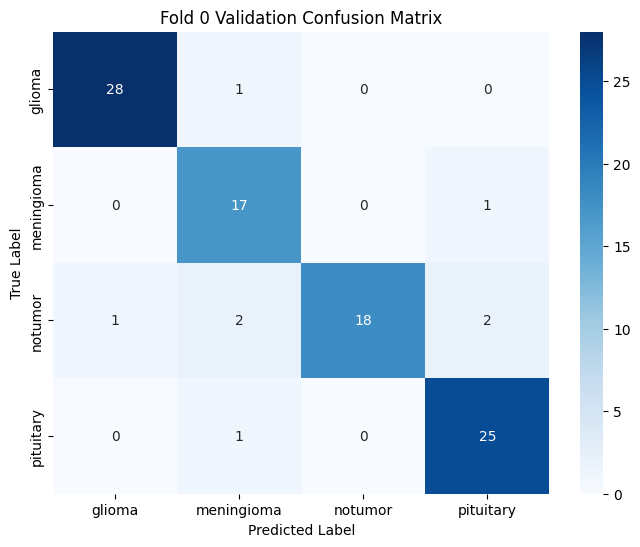

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97        29
  meningioma       0.81      0.94      0.87        18
     notumor       1.00      0.78      0.88        23
   pituitary       0.89      0.96      0.93        26

    accuracy                           0.92        96
   macro avg       0.92      0.91      0.91        96
weighted avg       0.92      0.92      0.92        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 28, TN: 66, FP: 1, FN: 1
Class: meningioma, TP: 17, TN: 74, FP: 4, FN: 1
Class: notumor, TP: 18, TN: 73, FP: 0, FN: 5
Class: pituitary, TP: 25, TN: 67, FP: 3, FN: 1
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 90ms/step
Fold 1 - AUC-ROC for class glioma: 0.9611
Fold 1 - AUC-ROC for class meningioma: 0.8946
Fold 1 - AUC-ROC for class notumor: 0.9918
Fold 1 - AUC-ROC for class pituitary: 0.9637


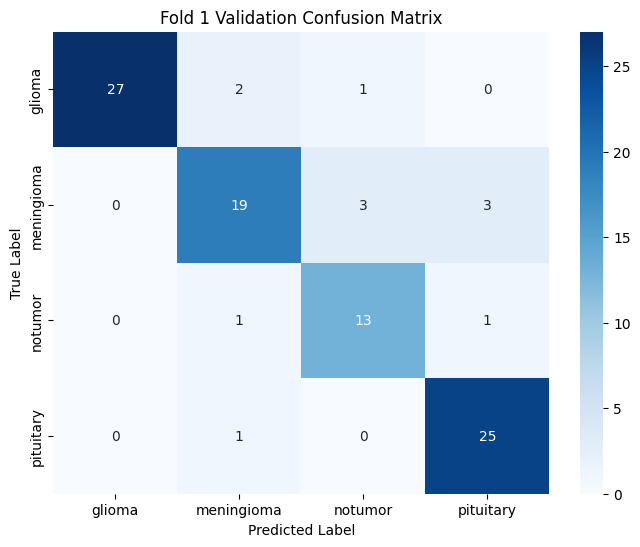

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       1.00      0.90      0.95        30
  meningioma       0.83      0.76      0.79        25
     notumor       0.76      0.87      0.81        15
   pituitary       0.86      0.96      0.91        26

    accuracy                           0.88        96
   macro avg       0.86      0.87      0.87        96
weighted avg       0.88      0.88      0.88        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 27, TN: 66, FP: 0, FN: 3
Class: meningioma, TP: 19, TN: 67, FP: 4, FN: 6
Class: notumor, TP: 13, TN: 77, FP: 4, FN: 2
Class: pituitary, TP: 25, TN: 66, FP: 4, FN: 1
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 87ms/step
Fold 2 - AUC-ROC for class glioma: 0.9922
Fold 2 - AUC-ROC for class meningioma: 0.9181
Fold 2 - AUC-ROC for class notumor: 0.9778
Fold 2 - AUC-ROC for class pituitary: 0.9745


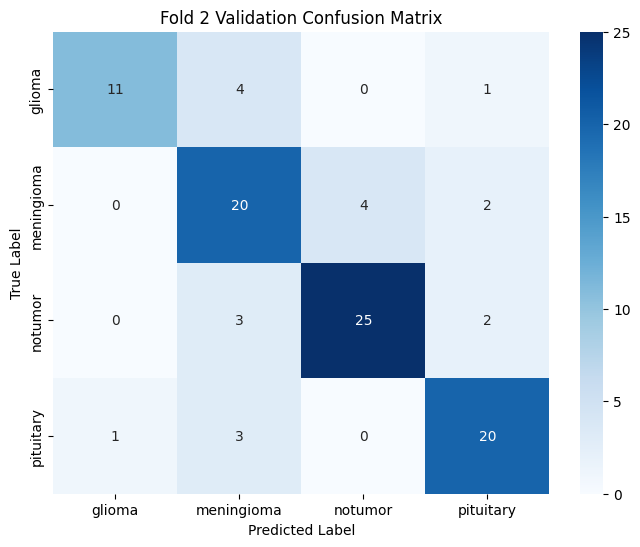

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.92      0.69      0.79        16
  meningioma       0.67      0.77      0.71        26
     notumor       0.86      0.83      0.85        30
   pituitary       0.80      0.83      0.82        24

    accuracy                           0.79        96
   macro avg       0.81      0.78      0.79        96
weighted avg       0.80      0.79      0.79        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 11, TN: 79, FP: 1, FN: 5
Class: meningioma, TP: 20, TN: 60, FP: 10, FN: 6
Class: notumor, TP: 25, TN: 62, FP: 4, FN: 5
Class: pituitary, TP: 20, TN: 67, FP: 5, FN: 4
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 91ms/step
Fold 3 - AUC-ROC for class glioma: 0.9803
Fold 3 - AUC-ROC for class meningioma: 0.9564
Fold 3 - AUC-ROC for class notumor: 0.9883
Fold 3 - AUC-ROC for class pituitary: 0.9988


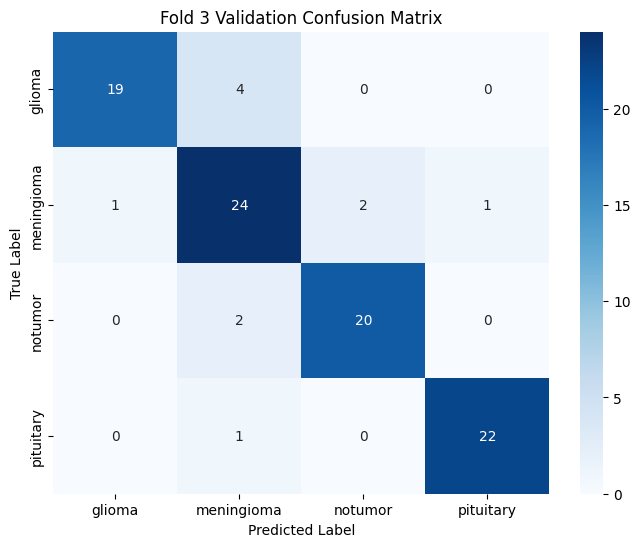

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88        23
  meningioma       0.77      0.86      0.81        28
     notumor       0.91      0.91      0.91        22
   pituitary       0.96      0.96      0.96        23

    accuracy                           0.89        96
   macro avg       0.90      0.89      0.89        96
weighted avg       0.89      0.89      0.89        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 19, TN: 72, FP: 1, FN: 4
Class: meningioma, TP: 24, TN: 61, FP: 7, FN: 4
Class: notumor, TP: 20, TN: 72, FP: 2, FN: 2
Class: pituitary, TP: 22, TN: 72, FP: 1, FN: 1
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 88ms/step
Fold 4 - AUC-ROC for class glioma: 0.9889
Fold 4 - AUC-ROC for class meningioma: 0.9559
Fold 4 - AUC-ROC for class notumor: 0.9884
Fold 4 - AUC-ROC for class pituitary: 0.9981


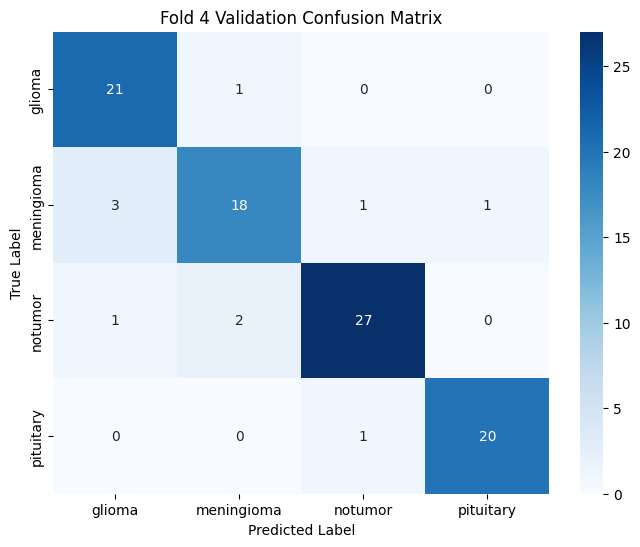

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.84      0.95      0.89        22
  meningioma       0.86      0.78      0.82        23
     notumor       0.93      0.90      0.92        30
   pituitary       0.95      0.95      0.95        21

    accuracy                           0.90        96
   macro avg       0.90      0.90      0.89        96
weighted avg       0.90      0.90      0.90        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 21, TN: 70, FP: 4, FN: 1
Class: meningioma, TP: 18, TN: 70, FP: 3, FN: 5
Class: notumor, TP: 27, TN: 64, FP: 2, FN: 3
Class: pituitary, TP: 20, TN: 74, FP: 1, FN: 1


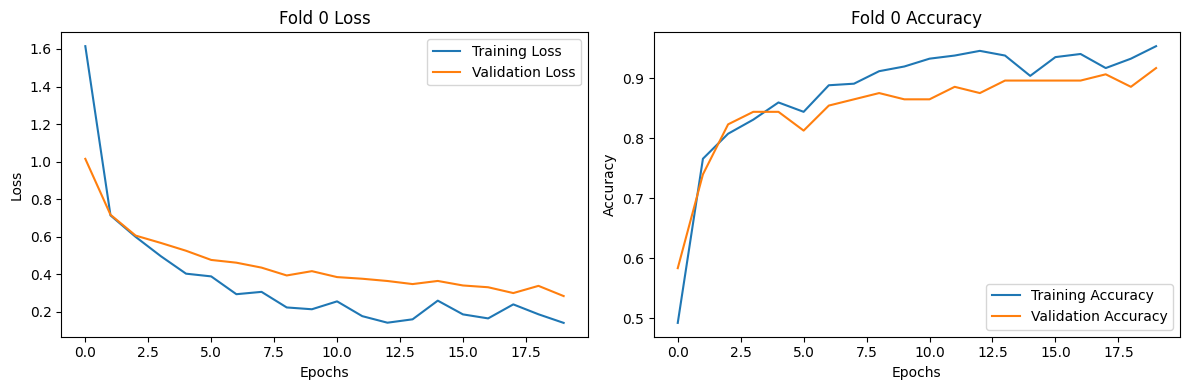

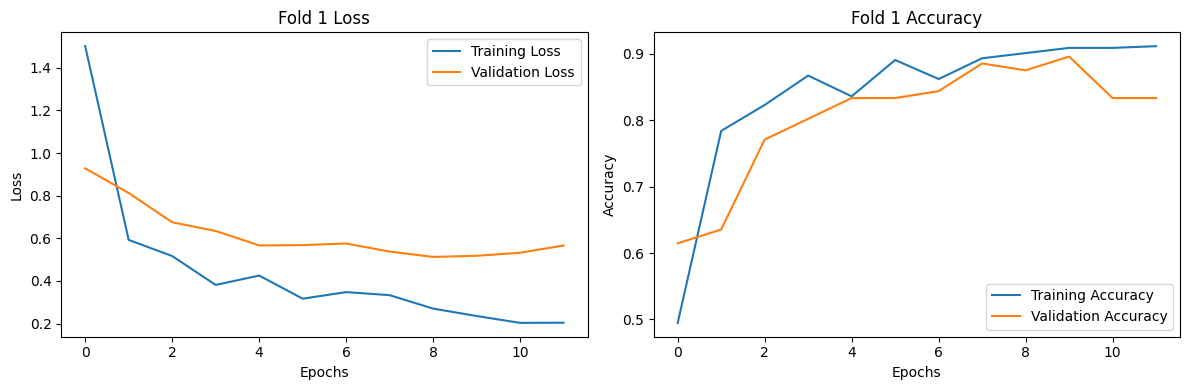

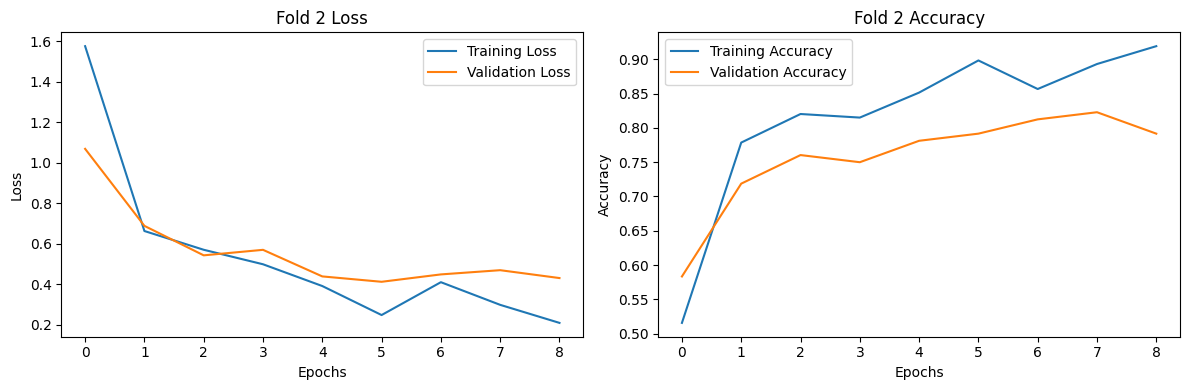

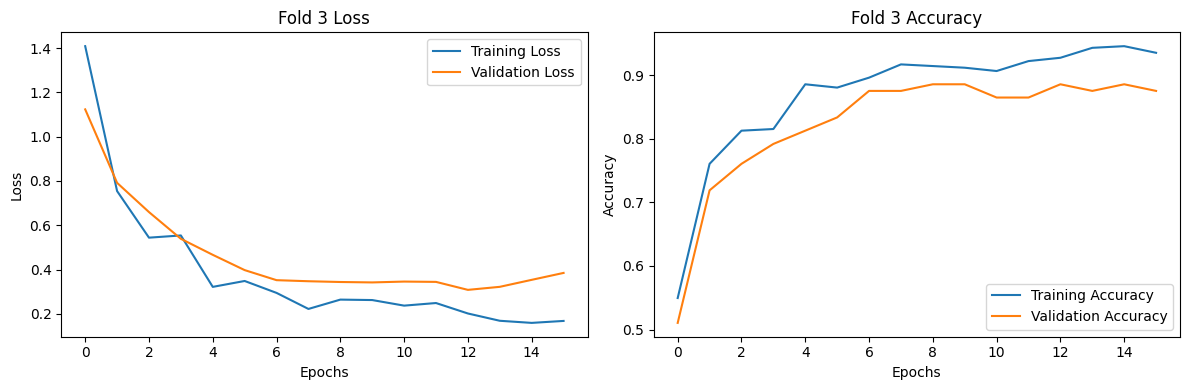

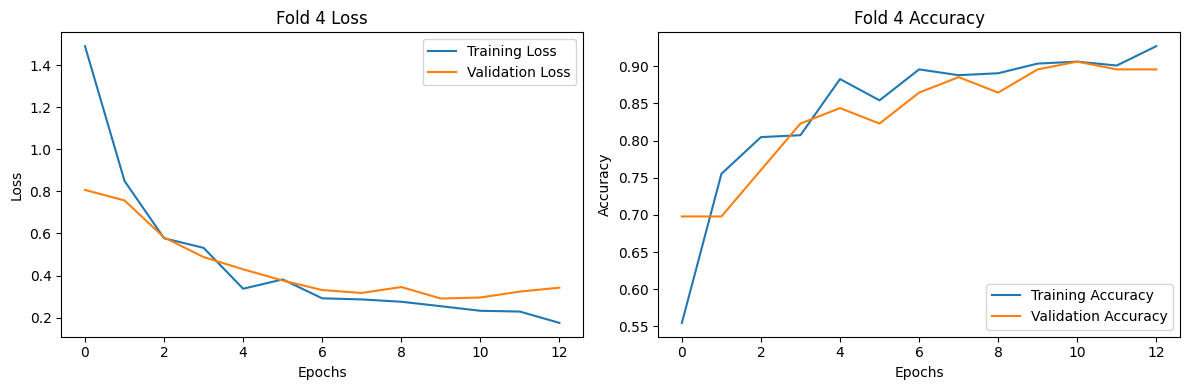

Accuracies for each fold:
Fold 0: 91.67%
Fold 1: 87.50%
Fold 2: 79.17%
Fold 3: 88.54%
Fold 4: 89.58%
Mean Validation Accuracy across all folds: 87.29%
Variance of Validation Accuracy across all folds: 0.18%


In [265]:
base_dir = 'dataset_kfold'

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []
models = []

for fold in range(5):
    print(f'Starting training for fold {fold}...')

    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    # Get the model and compile it
    num_classes = len(train_generator.class_indices)
    model = get_mobilenetv2_model(num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(model, train_generator, val_generator, num_epochs=20, patience=3)
    models.append(model)  # Save the model in the list for further evaluation

    # Collecting results for plotting
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')

# Detailed Evaluation for Each Fold
for fold in range(5):
    model = models[fold]  # Load the model from the list

    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    val_predictions = model.predict(val_generator)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

    val_true_classes_one_hot = tf.keras.utils.to_categorical(val_true_classes, num_classes)
    auc_roc_scores = {}
    for i, class_name in enumerate(val_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_classes_one_hot[:, i], val_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        auc_roc_scores[class_name] = roc_auc
        print(f'Fold {fold} - AUC-ROC for class {class_name}: {roc_auc:.4f}')

    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions_classes, target_names=list(val_generator.class_indices.keys())))

    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")

# Plotting Results
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Training Loss')
        plt.plot(all_val_losses[fold], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Training Accuracy')
        plt.plot(all_val_accuracies[fold], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")

# Calculate and print mean and variance of validation accuracies
mean_val_acc = np.mean(fold_accuracies)
var_val_acc = np.var(fold_accuracies)
print(f"Mean Validation Accuracy across all folds: {mean_val_acc * 100:.2f}%")
print(f"Variance of Validation Accuracy across all folds: {var_val_acc * 100:.2f}%")

## Image Prediction

1/1 [==============================] - 0s 399ms/step


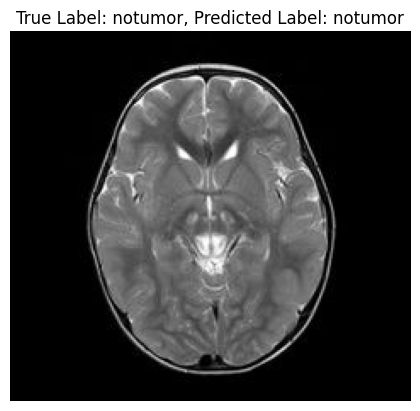

True Label: notumor
Predicted Label: notumor


In [266]:
# Function to predict the class of a single image
def predict_image(image_path, model, target_size):
    img = tf.keras.utils.load_img(image_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]

# Select the fold with the best accuracy
best_fold = np.argmax(fold_accuracies)

# Randomly select an image from the dataset and predict using the best model
val_dir = os.path.join(base_dir, f'fold_{best_fold}', 'val')
class_names = os.listdir(val_dir)
random_class = random.choice(class_names)
random_image = random.choice(os.listdir(os.path.join(val_dir, random_class)))
random_image_path = os.path.join(val_dir, random_class, random_image)

# Predict the class of the random image
predicted_class = predict_image(random_image_path, models[best_fold], (224, 224))

# Load the image for display
img = Image.open(random_image_path)
plt.imshow(img)
plt.title(f'True Label: {random_class}, Predicted Label: {list(val_generator.class_indices.keys())[predicted_class]}')
plt.axis('off')
plt.show()

# Print true and predicted labels
print(f'True Label: {random_class}')
print(f'Predicted Label: {list(val_generator.class_indices.keys())[predicted_class]}')